##  Download & Import required pacages

In [ ]:
!pip install -q --upgrade pip
!pip install -q matplotlib
!pip install -q math
!pip install -q numpy
!pip install -q copy
!pip install -q keras

In [2]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
import math
import copy

## Load Database and normalize

In [3]:
def label_set(y, last_layer_lengh):
  label_list = []
  for label_value in y:
    label_vector = np.zeros((last_layer_lengh,1))
    label_vector[label_value, 0] = 1
    label_list.append(label_vector)

  return label_list

In [14]:
def load_train_set():
    # Reading The Train Set
    train_images_file = open('train-images.idx3-ubyte', 'rb')
    train_images_file.seek(4)
    num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
    train_images_file.seek(16)

    train_labels_file = open('train-labels.idx1-ubyte', 'rb')
    train_labels_file.seek(8)

    train_set = []
    for n in range(num_of_train_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
        
        label_value = int.from_bytes(train_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        
        train_set.append((image, label))
    return train_set


In [15]:
def load_test_set(): 
    # Reading The Test Set
    test_images_file = open('t10k-images.idx3-ubyte', 'rb')
    test_images_file.seek(4)

    test_labels_file = open('t10k-labels.idx1-ubyte', 'rb')
    test_labels_file.seek(8)

    num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
    test_images_file.seek(16)

    test_set = []
    for n in range(num_of_test_images):
        image = np.zeros((784, 1))
        for i in range(784):
            image[i] = int.from_bytes(test_images_file.read(1), 'big') / 256
        
        label_value = int.from_bytes(test_labels_file.read(1), 'big')
        label = np.zeros((10, 1))
        label[label_value, 0] = 1
        
        test_set.append((image, label))
    
    return test_set


In [16]:
train_set = load_train_set()
test_set = load_test_set()

In [9]:
train_X = [item[0] for item in train_set]
train_y = [item[1] for item in train_set]
test_X = [item[0] for item in test_set]
test_y = [item[1] for item in test_set]

In [ ]:
def create_batch_list( train_X, train_y, batch_size):
  train_X_batch_list = [train_X[i:i+batch_size] for i in range(0, len(train_X), batch_size)]
  train_y_batch_list = [train_y[i:i+batch_size] for i in range(0, len(train_X), batch_size)]
  batch_list = [zip(train_X_batch_list[i], train_y_batch_list[i]) for i in range(len(train_y_batch_list))]
  return batch_list

In [18]:
from collections import Counter
def check_data_distribution():
  print("train classes: ", set(train_y))
  print("test classes: ", set(test_y))
  train_dist = Counter(train_y)
  print(train_dist)
  test_dist = Counter(test_y)
  print(test_dist)
  return train_dist, test_dist

In [19]:
def barchart_ploter(dist_dict):
  bars = list(dist_dict.keys())
  hight = list(dist_dict.values())
  plt.bar(bars, hight, width = 0.4)
  plt.xlabal("numbers")
  plt.ylabal("distribution")
  plt.show()

In [10]:
def check_data(index):
  print("label: ",train_y[index])
  plt.imshow(train_X[index])

## Forward Phase

In [32]:
def W_init(row, col):
    # random_w_list = np.random.uniform(low = 0, high = 1, size = row *col)
    # random_w_matrix = random_w_list.reshape(row,col)
    random_w_list = np.random.normal(0, 1, size = (row,col))
    return random_w_list


In [33]:
def b_init(row):
    # np.random.uniform(low = 0.0, high = 1.0, size = row)
    random_b_list = np.zeros((row,1)) 
    random_b_matrix = random_b_list.reshape(row,1)
    return random_b_matrix

In [34]:
def init_matrix(matrix_layer_list):
    W_list = []
    b_list = []
    for layer_index in range(len(matrix_layer_list)-1):
      W_list.append(W_init(matrix_layer_list[layer_index+1], matrix_layer_list[layer_index]))
      b_list.append(b_init(matrix_layer_list[layer_index+1]))

    return W_list, b_list

In [35]:
def Sigmoid(x):
  result = 1/(1+ np.exp(-x))
  return result

In [36]:
def next_leyar_activation_calculator(matrix_W, b_vector, a_vector):
  resault_vector = Sigmoid((matrix_W @ a_vector) + b_vector)
  return resault_vector 

In [37]:
def forward(input_data, W_list, b_list):
  a_list = [input_data]
  for i in range(len(W_list)):
    res =next_leyar_activation_calculator(W_list[i], b_list[i], a_list[i])
    a_list.append(res)
  return a_list

## Backward Phase

In [39]:
def Sigmoid_derivate(x):
  s = Sigmoid(x)
  result = s * (1-s)
  return result

In [40]:
def calculate_layer_dervatives(a_vector, b_vector, matrix_w, dcost_da_vector, layer_num):
  z = (matrix_w @ a_vector) + b_vector
  b_derivative =  dcost_da_vector * Sigmoid_derivate(z)
  row, col = matrix_w.shape
  a_derivative = np.zeros((col,1))
  w_derivative = b_derivative @ np.transpose(a_vector)
  if layer_num  != 0:
    a_derivative = np.transpose(matrix_w) @ b_derivative

  return b_derivative, a_derivative, w_derivative

In [41]:
def backpropagation_dev_calculator(a_list, b_list, w_list, label):
  dcost_da_last_layer = 2*(a_list[-1] - label)
  layers_num = len(b_list)
  dcost_da_list = [0 for i in range(len(b_list))]
  dcost_da_list[layers_num-1] = dcost_da_last_layer
  
  db_list = []
  dw_list = []
  for i in range(layers_num-1, -1, -1):
    db, da, dw = calculate_layer_dervatives(a_list[i], b_list[i], w_list[i], dcost_da_list[i], i)
    db_list.append(db)
    dw_list.append(dw)
    dcost_da_list[i-1] = da
  
  return db_list[::-1], dw_list[::-1]


In [42]:
def backpropagation_grad_calculator(w_list, b_list, batch):

  Gw_list = [np.zeros(mat.shape) for mat in w_list]
  Gb_list = [np.zeros(mat.shape) for mat in b_list]
  for image, label in batch:
    # print("back_grad_Cal", image.shape)
    a_list = forward(image, w_list, b_list)
    db_list, dw_list = backpropagation_dev_calculator(a_list, b_list, w_list, label)
    for index in range(len(Gw_list)):
      Gw_list[index] += dw_list[index]
      Gb_list[index] += db_list[index]
      
  return Gw_list, Gb_list



In [44]:
def cost(w_list, b_list, train_X, train_y):
  cost_value = 0 
  for sample, label in zip(train_X, train_y):
    
    a_list = forward(sample,w_list, b_list)
    predicted_label = a_list[-1]
    cost_value += ((predicted_label - label)**2) 

  return cost_value/len(train_X)


In [45]:
def calculate_cost(batch, weights_matrix_list, bias_list):
    cost = 0
    for image, label in batch:
        predicted_output = forward(image, weights_matrix_list, bias_list)
        cost += (np.linalg.norm(predicted_output[-1] - label))
    return cost/len(batch)
    

## Train and evaluation

In [46]:
from tqdm import tqdm
def SGD(matrix_layer_list, learning_rate, batch_size, epoch, train_X, train_y):
  w_list, b_list = init_matrix(matrix_layer_list)
  cost_list = []
  for i in tqdm(range(epoch)):
    batch_list = create_batch_list( train_X, train_y, batch_size)
    for batch in batch_list:
      Gw_list, Gb_list = backpropagation_grad_calculator(w_list, b_list, batch)
      for index in range(len(w_list)):
        w_list[index] -= (learning_rate * Gw_list[index])/ batch_size
        b_list[index] -= (learning_rate * Gb_list[index])/ batch_size
    cost_list.append(cost(w_list, b_list,train_X, train_y))
  return cost_list, w_list, b_list

In [47]:
def cal_accuracy(test_X, test_y, w_list, b_list):
  correct_prediction_num = 0
  for img, label in zip(test_X, test_y):
    a_list = forward(img, w_list, b_list )
    predicted_label = a_list[-1]
    if np.argmax(predicted_label, axis=0)== np.argmax(label, axis=0):
      correct_prediction_num += 1
  return (correct_prediction_num/len(test_X))*100   

In [48]:
def show_result(test_X, test_y, w_list, b_list, cost_list):
  acc = cal_accuracy(test_X, test_y, w_list, b_list)
  print(acc)
  norm_list = [(np.linalg.norm(x)**2) for x in cost_list]
  plt.plot(norm_list)
  plt.show()



In [49]:
def main(epoch_num):
  matrix_layer_list = [28*28, 8*8, 16, 10]
  
  cost_list, w_list1, b_list1 = SGD(matrix_layer_list, 2, 32, epoch_num, train_X, train_y)
  show_result(test_X, test_y, w_list1, b_list1, cost_list)
  



100%|██████████| 20/20 [10:17<00:00, 30.87s/it]


94.78


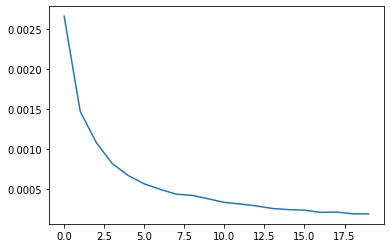

In [50]:
main(20)
